# Project name: 
    The Functional Neuroanatomy of the Human Subthalamic Nucleus
    
    Initial code by Gilles de Hollander; 
    Edited by Steven Miletic and Max Keuken

# Goal of the project: 
    To investigate the internal organisation of the human subthalamic nucleus using histology. The non-demented control tissue has been originally analyzed by Gilles de Hollander. 

# Layout of the Notebook
### 1) Combine and store the data:
    1a) Background-correct png-files of specimen 15-035
    1b) import histo data into a HDF5 file that contains the histo data and the STN masks in the folder:
       /home/stevenm/data/post_mortem/new_data_format/

### 2) Plot the data:
    2) load in the HDF5 data files using the base.py script. The base.py script loads in the data, sets the resolution but also smooths the data with a number of smoothing kernels (0.15, 0.3, 0.6, 1.2, and 2.4 mm fwhm). The reason why we have such a large number of smoothing kernels is because we ran a simulation to generate a hypothesis figure. Here we noted that if the smoothing kernel was too small the histograms were very noisy, if the smoothing kernel was very large you cannot find small transition zones. So there needed to be a bit of a balance. We decided to run the entire analysis for the 5 different smoothing kernels. The final choice of fwhm to report in the main manuscript was based on consistency accross tissue blocks, the other kernels were placed in the supplements.  

### 3) Statistical analysis of the 27 PCA intensity sectors
    3a) Creating the 27 PCA sectors where for each stain, across the subjects we will test whether they differ from 0
    3b) Doing the actual statistical testing: t-tests which are FDR corrected for multiple comparisons.

### 4) GLM fitting 
    4a1) Creating a dataframe using 1000 PCA sectors
    4a2) Fit the GLMs
    4b) Quality of fit checks
    4c) Model comparison
    4d) Visualize overall model fits

### 1) Combine and store the data 

#### Specimen 15035 background-correction
This specimen had high staining intensity, causing the scanner to increase the luminance, leading to background-values of the png-images to be > 0.
For statistical modelling, this is an issue, since values > 0 are interpreted as reflecting staining. 

To circumvent this issue, we estimate the background intensity as the minimum measured intensity in the four corners of the image (patches of 100x100 voxels), and reset this value to 0.

In [2]:
from scipy import ndimage
from imageio import imwrite
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# find pngs
orig_dir = '/home/stevenm/data/post_mortem/original_slides_15035_without_background_fix/15035_png/'
new_dir = '/home/stevenm/data/post_mortem/stacked_slides/15035_png/'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
all_pngs = glob.glob(orig_dir + '*.png')

# loop over pngs
for png in all_pngs:
    img = ndimage.imread(png)
    min_in_corner0 = np.min(img[:100, :100]) # upper left
    min_in_corner1 = np.min(img[:100, -100:]) # upper right
    min_in_corner2 = np.min(img[-100:, :100]) # lower left
    min_in_corner3 = np.min(img[-100:, -100:]) # lower right

    # estimate median of background values
    background_median = np.median([min_in_corner0, min_in_corner1, min_in_corner2, min_in_corner3])
    
    # Set everything at or below this median to 0
    img[img<=background_median] = 0
    
    # save to new directory
    imwrite(new_dir + png.split('/')[-1], img)

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


#### Importing the histological data as well as the masks of the STN and save them into a HDF5 file.

In [3]:
import re
import pandas
import glob
import h5py
import scipy as sp
from scipy import ndimage
import natsort
import numpy as np
import os

# Find the stains.png images per tissue blocks that have been registered to the blockface images
fns = glob.glob('/home/stevenm/data/post_mortem/stacked_slides/*/*')
reg = re.compile('.*/(?P<subject_id>[0-9]{5})_png/(?P<stain>[A-Za-z0-9]+)_(?P<slice>[0-9]+)_[0-9]+_(?P<id>[0-9]+)\.png')

df = pandas.DataFrame([reg.match(fn).groupdict() for fn in fns if reg.match(fn)])
df['subject_id'] = df['subject_id'].astype(int)
df['slice'] = df['slice'].astype(int)
df['fn'] = [fn for fn in fns if reg.match(fn)]
df['id'] = df['id'].astype(int)
# There were a number of stains where there were 2 images. The first image was before the tissue block
#  was moved forwards again during the cutting. The second image was once the cutting continued. We chose
#  to only keep the second image:
df = df.drop_duplicates(['subject_id', 'slice', 'stain'], keep='last')

# The naming conventions of the stains was lower case so rename to match to uppercase
def correct_stain(stain):
    if stain == 'calr':
        return 'CALR'
    
    if stain == 'fer':
        return 'FER'

    if stain == 'gabra3':
        return 'GABRA3'
    
    if stain == 'gad6567':
        return 'GAD6567'
    
    if stain == 'mbp':
        return 'MBP'
    
    if stain == 'parv':
        return 'PARV'    
        
    if stain == 'sert':
        return 'SERT' 
    
    if stain == 'smi32':
        return 'SMI32' 
    
    if stain == 'syn':
        return 'SYN'   
    
    if stain == 'th':
        return 'TH' 
    
    if stain == 'transf':
        return 'TRANSF' 
    
    if stain == 'vglut1':
        return 'VGLUT1'
    
    return stain

df['stain'] = df.stain.map(correct_stain).astype(str)

# Make a data structure that will be used for combining the histo data
df.to_pickle('/home/stevenm/data/post_mortem/data.pandas')

# Find the masks of the STN that were based of two raters who parcellated the STN using the PARV and SMI32 stains.
reg3 = re.compile('/home/stevenm/data/post_mortem/histo_masks/(?P<subject_id>[0-9]{5})_RegMasks_(?P<rater>[A-Z]+)/(?P<stain>[A-Z0-9a-z_]+)_(?P<slice>[0-9]+)_([0-9]+)_(?P<id>[0-9]+)\.png')

fns = glob.glob('/home/stevenm/data/post_mortem/histo_masks/*_RegMasks_*/*_*_*_*.png')

masks = pandas.DataFrame([reg3.match(fn).groupdict() for fn in fns])
masks['fn'] = fns
masks['subject_id'] = masks['subject_id'].astype(int)
masks['slice'] = masks['slice'].astype(int)

masks.set_index(['subject_id', 'slice', 'stain', 'rater'], inplace=True)
masks.sort_index(inplace=True)

# masks.to_pickle('/home/stevenm/data/post_mortem/masks.pandas')

mask_stains = ['PARV', 'SMI32']
raters_a = ['KH', 'MT']

# There were a few masks missing (either due to not correct saving or skipping), so MCKeuken and AAlkemade parcellated the 
# remaing ones
raters_b = ['MCK', 'AA']

# A for loop that creates the .HDF5 files per tissue block 
for subject_id, d in df.groupby(['subject_id']):
    print(subject_id)
    
    slices = natsort.natsorted(d.slice.unique())
    
    print(slices)
    
    stains = natsort.natsorted(d.stain.unique())
    resolution = ndimage.imread(d.fn.iloc[0]).shape

    data_array = np.zeros((len(slices),) + resolution + (len(stains),))
    data_array[:] = np.nan
    
    print('Storing data')
    for idx, row in d.iterrows():
        
        slice_idx = slices.index(row['slice'])
        stain_idx = stains.index(row['stain'])
        
        data_array[slice_idx, ..., stain_idx] = ndimage.imread(row.fn)
        
    mask_array = np.zeros((len(slices),) + resolution + (4,))
    
    print('Storing masks')
    for idx, row in masks.ix[subject_id].reset_index().iterrows():
        
        slice_idx = slices.index(row['slice'])
        
        if row.rater in raters_a:
            last_idx = mask_stains.index(row.stain) * 2 + raters_a.index(row.rater)
        else:
            last_idx = mask_stains.index(row.stain) * 2 + raters_b.index(row.rater)
        
        im = ndimage.imread(row.fn)
        mask_array[slice_idx, ..., last_idx] = im > np.percentile(im, 70)

15035
[700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100]


/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:101: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Storing data


/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:112: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Storing masks


/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:117: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:126: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


### 2) Plot the data:
#### There are two different types of plots that we are going for here. The first type is a plot that displays the intensity histogram of the stain which is combined with a tri-planner view of the STN. This is done per subject and stain. The second type of plot is used to check whether the MRI data aligns with the blockface images, whether the stains align with the blockface images, and finally whether the masks of the STN are located in a plausible location. 

#### It should be noted that we are not using the intensity per pixel but that we smooth the data a bit. Namely with a Gaussian smoothing kernel 0.3mm fwhm. For the original analysis we also used 0.15mm fwhm. 

In [1]:
############
# What does the data look like?
############
# To visualize the data we plot the stacked stains in a tri-planner view. This allows us to check whether there
#   are slices that are still completely misaligned. 
# We also create an intensity histogram to get an initial feeling for how the data distribution looks like.
#
# Given the high resolution of the data and that we are interested in the distribution thoughout the STN we decided 
#   to smooth the data a bit using a 0.3 mm fwhm Gaussian kernel. 
#
############
# Start code
############
#
# Importing a number of different tools
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from pystain import StainDataset
import os
import numpy as np

import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

# Which tissue blocks are we going to visualize? 
subject_ids = [13095, 14037, 14051, 14069, 15033, 15035, 15055]

# Ensure that the color coding is normalized between the min and max per stain
def cmap_hist(data, bins=None, cmap=plt.cm.hot, vmin=None, vmax=None):
    n, bins, patches = plt.hist(data, bins=bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()

    # scale values to interval [0,1]
    col = (bin_centers - vmin) / vmax

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cmap(c))

fwhm = 0.3
# Create the figures per stain, per tissue block, per smoothing kernel [0.15, 0.3, 0.6, 1.2, 2.4].
for subject_id in subject_ids[:]:
    dataset = StainDataset(subject_id, fwhm=fwhm)
    dataset.get_vminmax((0, 99))

    d = '/home/stevenm/data/post_mortem/visualize_stains_v2/%s/' % (subject_id)

    if not os.path.exists(d):
        os.makedirs(d) 

    fn = os.path.join(d, 'stains_%s.pdf' % fwhm)
    if os.path.isfile(fn):
        continue
    pdf = PdfPages(fn)

    for i, stain in enumerate(dataset.stains):
        print('Plotting %s' % stain)
        plt.figure()
        # thresholded mask area is where at least 3 masks overlay
        data = dataset.smoothed_data.value[dataset.thresholded_mask, i]
        data = data[~np.isnan(data)]
        bins = np.linspace(0, dataset.vmax[i], 100)
        cmap_hist(data, bins, plt.cm.hot, vmin=dataset.vmin[i], vmax=dataset.vmax[i])
        plt.title(stain)
        plt.savefig(pdf, format='pdf')

        plt.close(plt.gcf())

        plt.figure()

        if not os.path.exists(d):
            os.makedirs(d)

        for i, orientation in enumerate(['coronal', 'axial', 'sagittal']):
            for j, q in enumerate([.25, .5, .75]):
                ax = plt.subplot(3, 3, i + j*3 + 1)
                slice = dataset.get_proportional_slice(q, orientation)
                dataset.plot_slice(slice=slice, stain=stain, orientation=orientation, cmap=plt.cm.hot)
                ax.set_anchor('NW')

        plt.gcf().set_size_inches(20, 20)
        plt.suptitle(stain)
        plt.savefig(pdf, format='pdf')
        plt.close(plt.gcf())

    pdf.close()

/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/14037/images.hdf5
calculating vmin
calculating vmax
Plotting CALR
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
Plotting FER
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
Plotting GABRA3
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
Plotting GAD6567
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
Plotting MBP
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
Plotting PARV
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
Plotting SERT
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
Plotting SMI32
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 1360)
Plotting SYN
(1704, 1360) (1704, 1360)
(1704, 1360) (1704, 136

KeyboardInterrupt: 

### 3) Statistical analysis of the 27 PCA sectors
3a) For each subject the data is collected, masked so that we only have the data in the masks, a two component PCA is run of which the first component is along the dorsal axis, whereas the second component is via the lateral axis. Then in the Y direction, or anterior/posterior axis, the structure is devided into three parts. Afterwards, for the lateral and dorsal PCA components, the line is devided into 3 parts. This is done for each Y slices, resulting in 3x3x3: 27 sectors. 

The data of those 27 sectors are then combined across subjects per stain. 


In [1]:
############
# Is the data uniformly distributed over the STN?
############
#
# To test this question we divide the STN into 27 sectors based on a PCA analysis where we identify the three main 
#   axes which are then each divided into three parts. 
#
# The mean intensity per stain is subtracted of each elipsoid, so that if the data is uniformly distributed each
#   sector would be equal to zero. If there are sectors that have a signal lower than the overall mean these sectors
#   will have a negative value and vice versa for higher signals. 
# 

# Importing a number of different tools
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import pandas
from pystain import StainDataset

# Start code
subject_id = 13095
ds = StainDataset(subject_id)

conversion_matrix = np.array([[0, 0, ds.xy_resolution],
                      [-ds.z_resolution, 0, 0],
                      [0, -ds.xy_resolution, 0]])
results = []

# What are the subject IDs?
subject_ids=[13095, 14037, 14051, 14069, 15033, 15035, 15055]

# What fwhm to use here?
fwhm = 0.3
for subject_id in subject_ids[:]:
    ds = StainDataset(subject_id, fwhm=fwhm)

    # Get coordinates of mask and bring them to mm
    x, y, z = np.where(ds.thresholded_mask)
    coords = np.column_stack((x, y, z))
    coords_mm = conversion_matrix.dot(coords.T).T
    coords_mm -= coords_mm.mean(0)

    # Fit two components and make sure first axis walks dorsal
    #   and second component lateral
    pca = PCA()
    pca.fit_transform((coords_mm - coords_mm.mean(0))[:, (0, 2)])

    components = pca.components_
    print(components)

    if components[0, 1] < 0:
        components[0] = -components[0]

    if components[1, 0] < 0:
        components[1] = -components[1]

    print(components)

    coords_dataframe = pandas.DataFrame(coords_mm, columns=['x_mm', 'y_mm', 'z_mm'])
    coords_dataframe['slice'] = x

    coords_dataframe['pc1'] = components.dot(coords_mm[:, (0, 2)].T)[0, :]
    coords_dataframe['pc2'] = components.dot(coords_mm[:, (0, 2)].T)[1, :]

    coords_dataframe[['pc1_slice_center', 'pc2_slice_center']] = coords_dataframe.groupby(['slice'])[['pc1', 'pc2']].apply(lambda x: x - x.mean())

    coords_dataframe['slice_3'] = pandas.qcut(coords_dataframe.y_mm, 3, labels=['posterior', 'middle', 'anterior'])    

    coords_dataframe['pc1_3'] = coords_dataframe.groupby('slice_3').pc1.apply(lambda d: pandas.qcut(d, 3, labels=['ventral', 'middle', 'dorsal']))
    coords_dataframe['pc2_3'] = coords_dataframe.groupby(['slice_3', 'pc1_3']).pc2.apply(lambda d: pandas.qcut(d, 3, labels=['medial', 'middle', 'lateral']))

    df = pandas.concat((ds.smoothed_dataframe, coords_dataframe), 1)
    tmp = df.pivot_table(index=['pc1_3', 'pc2_3', 'slice_3'], values=ds.stains, aggfunc='mean').copy()
    tmp['subject_id'] = subject_id
    tmp['fwhm'] = fwhm

    results.append(tmp.copy())

df = pandas.concat(results).reset_index().set_index(['subject_id', 'slice_3', 'pc1_3', 'pc2_3'])
df = pandas.melt(df.reset_index(), id_vars=['fwhm', 'subject_id', 'slice_3', 'pc1_3', 'pc2_3'], var_name='stain')
df['value'] = df.groupby(['fwhm', 'subject_id', 'stain']).transform(lambda x: (x - x.mean()) / x.std())

/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
[[-0.98094749 -0.19427308]
 [-0.19427308  0.98094749]]
[[ 0.98094749  0.19427308]
 [ 0.19427308 -0.98094749]]
/home/stevenm/data/post_mortem/new_data_format/14037/images.hdf5
[[-0.95611755 -0.29298334]
 [ 0.29298334 -0.95611755]]
[[ 0.95611755  0.29298334]
 [ 0.29298334 -0.95611755]]
/home/stevenm/data/post_mortem/new_data_format/14051/images.hdf5
[[-0.78933812 -0.61395874]
 [ 0.61395874 -0.78933812]]
[[ 0.78933812  0.61395874]
 [ 0.61395874 -0.78933812]]
/home/stevenm/data/post_mortem/new_data_format/14069/images.hdf5
[[-0.70764237 -0.70657079]
 [ 0.70657079 -0.70764237]]
[[ 0.70764237  0.70657079]
 [ 0.70657079 -0.70764237]]
/home/stevenm/data/post_mortem/new_data_format/15033/images.hdf5
[[-0.66358108 -0.74810437]
 [ 0.74810437 -0.66358108]]
[[ 0.66358108  0.74810437]
 [ 0.74810437 -0.66358108]]
/home/stevenm/data/post_mortem/new_data_format/15035/images.

### 3) Statistical analysis of the 27 PCA sectors
#### 3b) For each stain and sector we do a simple t-test to compare whether the intensity values are different from zero. This is corrected for multiple comparisons using a fdr correction, critical p-value of 0.05.

#### The sectors that survive the fdr correction are then plotted on the elipsoid, where red indicates above average intensity, blue indicates below average intensity. 
 

0.0 2
CALR
[[2.48573088e-01 5.43580173e-03 1.50054228e-01]
 [3.96414114e-05 3.96414114e-05 9.72362314e-05]
 [9.72362314e-05 3.96414114e-05 5.21209344e-04]]
0.0 1


/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:87: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:88: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:89: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/stevenm/anaconda2/envs/python3/lib/python3.

CALR
[[1.90607499e-01 8.90261148e-02 2.88099968e-02]
 [2.05604273e-03 4.55511700e-05 1.90607499e-01]
 [4.55511700e-05 5.98204755e-04 1.44478426e-01]]
0.0 0
CALR
[[4.02033106e-04 2.13320169e-04 2.13320169e-04]
 [3.12283574e-02 1.52332480e-02 1.05782768e-03]
 [2.50749233e-01 2.37618459e-01 2.37618459e-01]]
1.0 2
FER
[[0.84631391 0.99748254 0.84631391]
 [0.84631391 0.84631391 0.84631391]
 [0.8886049  0.84631391 0.84631391]]
1.0 1
FER
[[0.66144605 0.66144605 0.84136821]
 [0.84136821 0.99210882 0.9358165 ]
 [0.84136821 0.66144605 0.84136821]]
1.0 0
FER
[[0.90352617 0.90352617 0.90352617]
 [0.91450853 0.90352617 0.91450853]
 [0.90352617 0.90352617 0.90352617]]
2.0 2
GABRA3
[[0.37826134 0.76987442 0.67491362]
 [0.05124997 0.37826134 0.76987442]
 [0.05124997 0.06209035 0.22645628]]
2.0 1
GABRA3
[[0.18813826 0.0936738  0.02364878]
 [0.43881176 0.74874785 0.39124387]
 [0.62864424 0.39124387 0.39124387]]
2.0 0
GABRA3
[[0.38169027 0.19558252 0.29436467]
 [0.96100126 0.38169027 0.38169027]
 [0.0993

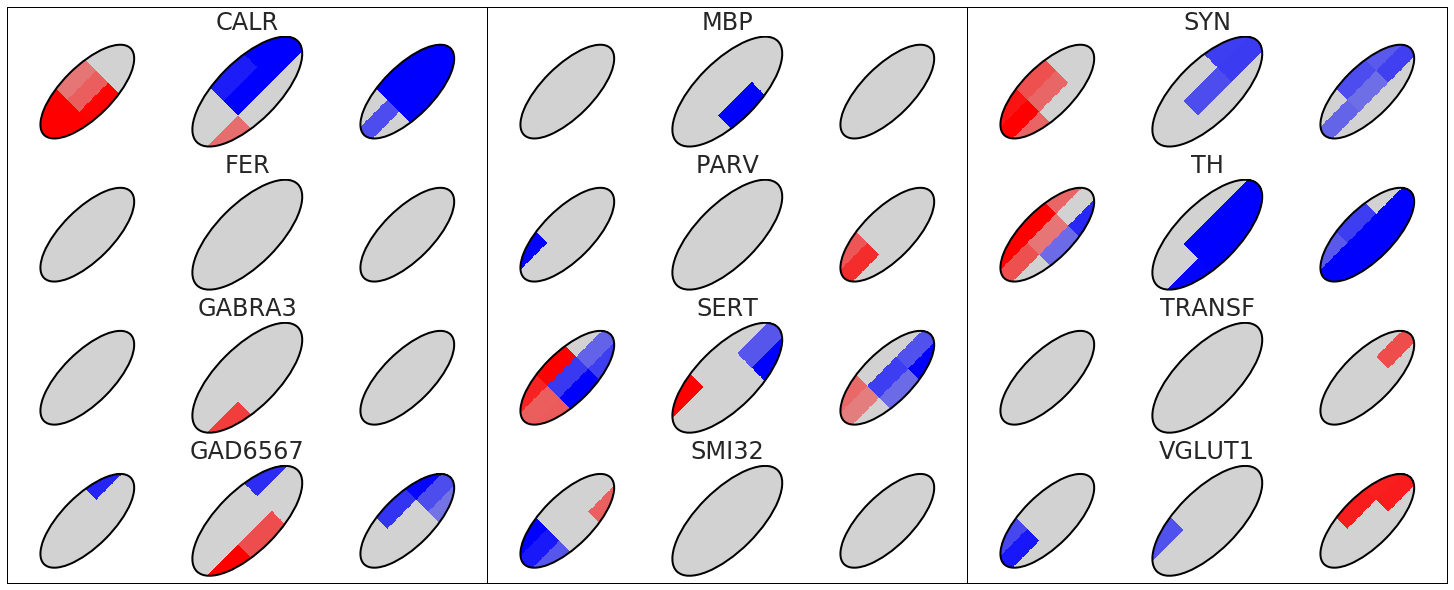

In [4]:
# Plot all stains together in a single figure
# Importing a number of different tools
from statsmodels.sandbox.stats import multicomp
import matplotlib
from matplotlib import patches
import scipy as sp
import seaborn as sns
sns.set_style('white')
df.stain.unique()
%matplotlib inline

# gray 'background' of STN instead of white
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colormap', ['blue', 'lightgray', 'red'])
def plot_ellipse_values(values, ellipse_pars=None, size=(1000, 1000), vmin=None, vmax=None, cmap=plt.cm.coolwarm, ax=None, **kwargs):

    ''' values is a n-by-m array'''

    values[np.isnan(values)] = 0
    if ellipse_pars is None:
        a = 350
        b = 150
        x = 500
        y = 500

        theta = 45. / 180 * np.pi

    else:
        a, b, x, y, theta = ellipse_pars

    A = a**2 * (np.sin(theta))**2 + b**2 * (np.cos(theta))**2
    B = 2 * (b**2 - a**2) * np.sin(theta) * np.cos(theta)
    C = a**2 * np.cos(theta)**2 + b**2 * np.sin(theta)**2
    D = -2 * A * x - B* y
    E = -B * x - 2 * C * y
    F = A* x**2 + B*x*y + C*y**2 - a**2*b**2

    X,Y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

    in_ellipse = A*X**2 + B*X*Y +C*Y**2 + D*X + E*Y +F < 0

    pc1 = np.array([[np.cos(theta)], [np.sin(theta)]])
    pc2 = np.array([[np.cos(theta - np.pi/2.)], [np.sin(theta - np.pi/2.)]])

    pc1_distance = pc1.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)
    pc2_distance = pc2.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)

    pc1_quantile = np.floor((pc1_distance / a + 1 ) / 2. * values.shape[0])
    pc2_quantile = np.floor((pc2_distance / b + 1 ) / 2. * values.shape[1])

    im = np.zeros_like(X, dtype=float)

    for pc1_q in np.arange(values.shape[0]):
        for pc2_q in np.arange(values.shape[1]):
            im[in_ellipse * (pc1_quantile == pc1_q) & (pc2_quantile == pc2_q)] = values[pc1_q, pc2_q]

    im = np.ma.masked_array(im, ~in_ellipse)
#     cmap.set_bad('grey')
    if ax is None:
        cax = plt.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    else:
        ax.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        cax = ax
#    sns.despine()

    return cax

fwhm = 0.3
# What is the output folder for the PCA figures:
pca_folder = '/home/stevenm/data/post_mortem/visualize_stains_v2/PCA_sectors/fwhm_%s' %fwhm
if not os.path.exists(pca_folder):
    os.makedirs(pca_folder) 

fig, axes = plt.subplots(nrows=4, ncols=3*3)

# For every stain and sector over the 7 subjects plot the data and test whether it differs from zero:
for ii, (stain, d) in enumerate(df.loc[df.fwhm==fwhm].groupby(['stain'])):
    fn = '/home/stevenm/data/post_mortem/visualize_stains_v2/PCA_sectors/fwhm_%s/combined_big_picture_coolwarm.pdf' %(fwhm)
    pdf = PdfPages(fn)
    column_set = int(np.floor(ii/4.))
    row_n = (ii)%4.

    for i, (slice, d2) in enumerate(d.groupby('slice_3')):
        print(row_n, ['anterior', 'middle', 'posterior'].index(slice) + 3*(column_set))
        ax = axes[int(row_n), ['anterior', 'middle', 'posterior'].index(slice) + int(3*(column_set))]
#            ax = plt.subplot(1, 3, ['anterior', 'middle', 'posterior'].index(slice) + 1)

        n = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: len(v)).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        t = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[0]).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        p = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[1]).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        mean = d2.groupby(['pc1_3', 'pc2_3']).value.mean().unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]

        # FDR: as we are doing 27 seperate t-tests we need to correct for multiple comparisons:
        p.values[:] = multicomp.fdrcorrection0(p.values.ravel())[1].reshape(3, 3)

        # Providing some parameters for plotting the figures
        if i == 1:
            a, b, x, y, theta  = 350, 150, 300, 275, 45
        else:
            a, b, x, y, theta  = 300, 125, 300, 275, 45.

        plot_ellipse_values(t[p<0.05].values, size=(600, 550), ellipse_pars=(a, b, x, y,  theta / 180. * np.pi), vmin=-7, vmax=7, cmap=cmap, ax=ax)

        e1 = patches.Ellipse((x, y), a*2, b*2,
                             angle=theta, linewidth=2, fill=False, zorder=2)

        ax.add_patch(e1)
        ax.set_xticks([])
        ax.set_yticks([])

        sns.despine(bottom=True, left=True, right=True)

        if slice == 'middle':
            ax.set_title(stain, fontsize=24)

        print(stain)
        print(p.values)

fig.set_size_inches(10.*2, 4.*2)
fig.subplots_adjust(hspace=.275, wspace=0.00, bottom=0.01, left=0.0, top=.95, right=1)

plt.plot([0, 0], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([0, 1], [1, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([1, 1], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([0, 1], [0, 0], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)

plt.plot([1/3., 1/3.], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([2/3., 2/3.], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
fig.savefig(pdf,  format='pdf')
pdf.close()

# 4. GLMS
   The plan is to fit a series of GLMs that estimate the intensity of a stain as a function of its spatial location along the PCA-axes. To do this, we need to increase the resolution of the data from 27 voxels (3x3x3) to 1000 voxels (10x10x10)

### 4a1) Create dataframe with voxel intensity as a function of space in 10x10x10-voxel PCA space

This is largely the same code as 3a.

In [5]:
# Importing a number of different tools
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import pandas
from pystain import StainDataset

# Start code
subject_id = 13095
ds = StainDataset(subject_id)

conversion_matrix = np.array([[0, 0, ds.xy_resolution],
                              [-ds.z_resolution, 0, 0],
                              [0, -ds.xy_resolution, 0]])
results = []

# What are the subject IDs?
subject_ids=[13095, 14037, 14051, 14069, 15033, 15035, 15055]

# how many sub-sections along each axis?
n_sectors_per_axis = 10

fhwm = 0.3    
for subject_id in subject_ids[:]:
    ds = StainDataset(subject_id, fwhm=fwhm)

    # Get coordinates of mask and bring them to mm
    x, y, z = np.where(ds.thresholded_mask)
    coords = np.column_stack((x, y, z))
    coords_mm = conversion_matrix.dot(coords.T).T
    coords_mm -= coords_mm.mean(0)

    # Fit two components and make sure first axis walks dorsal
    #   and second component lateral
    pca = PCA()
    pca.fit_transform((coords_mm - coords_mm.mean(0))[:, (0, 2)])

    components = pca.components_
    print(components)

    if components[0, 1] < 0:
        components[0] = -components[0]

    if components[1, 0] < 0:
        components[1] = -components[1]

    print(components)

    # principal components
    coords_dataframe = pandas.DataFrame(coords_mm, columns=['x_mm', 'y_mm', 'z_mm'])
    coords_dataframe['slice'] = x

    coords_dataframe['pc1'] = components.dot(coords_mm[:, (0, 2)].T)[0, :]
    coords_dataframe['pc2'] = components.dot(coords_mm[:, (0, 2)].T)[1, :]

    coords_dataframe[['pc1_slice_center', 'pc2_slice_center']] = coords_dataframe.groupby(['slice'])[['pc1', 'pc2']].apply(lambda x: x - x.mean())

    # cut along axes
    coords_dataframe['slice_sector'] = pandas.qcut((x-1)*ds.z_resolution, n_sectors_per_axis)
    coords_dataframe['slice_mm'] = coords_dataframe['slice_sector'].apply(lambda x: x.mid)
    coords_dataframe['pc1_sector'] = coords_dataframe.groupby('slice_mm')['pc1'].apply(lambda d: pandas.qcut(d, n_sectors_per_axis))
    coords_dataframe['pc1_mm'] = coords_dataframe['pc1_sector'].apply(lambda x: x.mid)
    coords_dataframe['pc2_sector'] = coords_dataframe.groupby(['slice_mm', 'pc1_mm'])['pc2'].apply(lambda d: pandas.qcut(d, n_sectors_per_axis))
    coords_dataframe['pc2_mm'] = coords_dataframe['pc2_sector'].apply(lambda x: x.mid)

    if fwhm is None:
        df = pandas.concat((ds.dataframe, coords_dataframe), 1)
    else:
        df = pandas.concat((ds.smoothed_dataframe, coords_dataframe), 1)
    df['n_voxels'] = 1
    tmp = df.pivot_table(index=['slice_mm', 'pc1_mm', 'pc2_mm'], values=ds.stains + ['n_voxels'], aggfunc='sum').copy()
    tmp['subject_id'] = subject_id

    results.append(tmp.copy())

df = pandas.concat([x.reset_index() for x in results])
df = df.melt(id_vars=['subject_id', 'slice_mm', 'pc1_mm', 'pc2_mm', 'n_voxels'], var_name='stain')

# get rate
df['rate'] = df['value']/pandas.to_numeric(df['n_voxels'])

# get location of voxels in slice/pc1/pc2-space in voxel number along that dimension (0, 1, ..., n_voxels)
def return_unique_id(x):
    dict_ = dict(zip(np.unique(x.values), np.arange(np.unique(x.values).shape[0])))
    return(dict_)

#     df = pandas.merge(df, df.groupby(['subject_id']).slice_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'slice_mm': 'slice_sector_number'}), how='left')
df = pandas.merge(df, df.groupby(['subject_id', 'slice_mm']).pc1_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'pc1_mm': 'pc1_sector_number', 'level_2': 'pc1_mm'}), how='left')
df = pandas.merge(df, df.groupby(['subject_id', 'slice_mm', 'pc1_sector_number']).pc2_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'pc2_mm': 'pc2_sector_number', 'level_3': 'pc2_mm'}), how='left')

# name voxels for groupby-options used in plotting
df['slice_sector_name'] = 'pma_' + np.round(df['slice_mm'],3).astype(str).values
df['pc1_sector_name'] = 'vmd_' + df['pc1_mm'].round(3).astype(str).values
df['pc2_sector_name'] = 'mml_' + df['pc2_mm'].round(3).astype(str).values

def to_norm(x):
    return (x-x.mean())/x.std()

# scale to norm
df['pc1_mm_norm'] = df.groupby(['subject_id', 'stain']).pc1_mm.apply(lambda x: to_norm(x))
df['pc2_mm_norm'] = df.groupby(['subject_id', 'stain']).pc2_mm.apply(lambda x: to_norm(x))
df['slice_mm_norm'] = df.groupby(['subject_id', 'stain']).slice_mm.apply(lambda x: to_norm(x))

fn = './data_fwhm-{}.pkl'.format(fwhm)
df.to_pickle(fn)

/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
[[-0.98094749 -0.19427308]
 [-0.19427308  0.98094749]]
[[ 0.98094749  0.19427308]
 [ 0.19427308 -0.98094749]]
/home/stevenm/data/post_mortem/new_data_format/14037/images.hdf5
[[-0.95611755 -0.29298334]
 [ 0.29298334 -0.95611755]]
[[ 0.95611755  0.29298334]
 [ 0.29298334 -0.95611755]]
/home/stevenm/data/post_mortem/new_data_format/14051/images.hdf5
[[-0.78933812 -0.61395874]
 [ 0.61395874 -0.78933812]]
[[ 0.78933812  0.61395874]
 [ 0.61395874 -0.78933812]]
/home/stevenm/data/post_mortem/new_data_format/14069/images.hdf5
[[-0.70764237 -0.70657079]
 [ 0.70657079 -0.70764237]]
[[ 0.70764237  0.70657079]
 [ 0.70657079 -0.70764237]]
/home/stevenm/data/post_mortem/new_data_format/15033/images.hdf5
[[-0.66358108 -0.74810437]
 [ 0.74810437 -0.66358108]]
[[ 0.66358108  0.74810437]
 [ 0.74810437 -0.66358108]]
/home/stevenm/data/post_mortem/new_data_format/15035/images.

### 4a2) We fit the following model specifications:

|Model N | Specification | Parameters | Interpretation |
|--------|:------------- |:---------- | ---------------|
| 1 | log(y) ~ 1, $\epsilon \sim Poisson$| $\beta_{intercept}$ | No change in expression across space |
| 2 | log(y) ~ pc_1 + pc_2 + pc_3, $\epsilon \sim Poisson$ | $\beta_{intercept}$,  $\beta_{pc_1}$, $\beta_{pc_2}$, $\beta_{pc_3}$ |  Linear change in 3 directions
| 3 | log(y) ~ $\mu$ + $sector_1$ + $sector_2$, $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, cutoff1, cutoff2, $\beta_{pc_1}$, $\beta_{pc_2}$ | 3 sectors, cut-off estimated
| 4 | log(y) ~  $\mu$ + sigmoid($sector_1$, cutoff1, k) + sigmoid($sector_2$, cutoff2, k) $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, $\beta_{pc_1}$, $\beta_{pc_2}$, cutoff1, cutoff2 | 3 sectors, cut-off estimated along projected axis

For all models, an alternative with a negative binomial distribution as the error distribution was also fitted since we observed overdispersions

NB: various important functions (e.g., likelihoods, the actual model specifications) are imported from utils.py

In [6]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import glob
import os
import pickle as pkl

from utils import *

def obj(pars, x, error_dist, model_n, pc1_mm_norm, pc2_mm_norm, slice_mm_norm):
    
    ev = get_ev(pars, model_n, pc1_mm_norm, pc2_mm_norm, slice_mm_norm)
    
    if error_dist == 'nbinom':
        alpha = pars[-1]
        ll = np.sum(np.log(nbinom_pdf(x, ev, alpha)))
    else:
        ll = np.sum(np.log(poisson_pdf(x, ev)))
        
    if not np.isfinite(ll):
        return np.inf

    return -ll

def fit(model_n, error_dist, data, disp=False, popsize=100, workers=None, **kwargs):           
    if not error_dist in ['nbinom', 'poisson']:
        raise(IOerror('Error dist must be nbinom or poisson'))
    x = data['rate'].values
    mu_bounds = [(-15, 200)]
   
    # Define bounds
    if model_n == 1:
        bounds = mu_bounds
        
    elif model_n == 2:
        beta_pc1_bounds = [(-2, 2)]
        beta_pc2_bounds = [(-2, 2)]
        beta_slice_bounds = [(-2, 2)]
        bounds = mu_bounds + beta_pc1_bounds + beta_pc2_bounds + beta_slice_bounds

    elif model_n >= 3:
        beta_pc1_bounds = [(0, 1)]
        beta_pc2_bounds = [(0, 1)]
        cutoff_1_bounds = [(0.2, 0.6)]
        cutoff_2_bounds = [(0.4, 0.8)]
        lambda_0_bounds = mu_bounds
        lambda_1_bounds = mu_bounds
        bounds = mu_bounds + beta_pc1_bounds + beta_pc2_bounds + cutoff_1_bounds + cutoff_2_bounds + lambda_0_bounds + lambda_1_bounds
        if model_n == 4:
            k_bounds = [(1e-10, 1)]
            bounds = bounds + k_bounds
        
    if error_dist == 'nbinom':
        tau_bounds = [(1e-10, 1)]
        bounds = bounds + tau_bounds
    
    # make tuple of arguments for objective function
    # rate, error distribution, model_n, and location
    _args = (x, error_dist, model_n, data['pc1_mm_norm'].values, data['pc2_mm_norm'].values, data['slice_mm_norm'].values)

    result = sp.optimize.differential_evolution(obj, bounds, _args, 
                                                polish=True, disp=disp, 
                                                maxiter=5000, popsize=20*len(bounds), 
                                                tol=1e-5,
                                                workers=workers, **kwargs)
    if 'seed' in kwargs:
        _ = kwargs.pop('seed')
    if 'init' in kwargs:
        _ = kwargs.pop('init')
    result2 = sp.optimize.minimize(obj, result.x, _args, method='SLSQP', bounds=bounds, **kwargs)
    
    # add number of data points, easy for BIC calculation later on
    result2['n_obs'] = x.shape[0]
    result2['bounds'] = bounds
    result2['deoptim'] = result

    return result2


# load data
df = pd.read_pickle('./data_fwhm-0.3.pkl')
subjects = df.subject_id.unique()
stains = df.stain.unique()
models = [4,3,2,1]
distributions = ['nbinom', 'poisson']

output_dir = './models_ML'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
idx = range(0, 12)

# loop over stains
for i in idx:
    stain = stains[i]
    
    # ..over subjects
    for subject in subjects:
        df_to_run = df.loc[(df.subject_id==subject) & (df.stain==stain),:]

        # remove outliers, defined as 5*IQR above median in log-space
        iqr = np.subtract(*np.percentile(np.log(df_to_run['rate']).values, [75, 25]))
        thresh = np.median(np.log(df_to_run['rate']))+5*iqr
        outlier_idx = np.log(df_to_run['rate']) > thresh
        print('{} outlying data points found...'.format(np.sum(outlier_idx)))
        df_to_run = df_to_run.loc[~outlier_idx]

        # ...over models
        for model_n in models:
            
            # ...and over errror distributions
            for distribution in distributions:
                print('Subject {}, stain {}, model {}, distribution {}'.format(subject, stain, model_n, distribution))
                fit_result_fn = os.path.join(output_dir, 'sub-{}_stain-{}_model-{}_distribution-{}_fitresult.pkl').format(subject, stain, model_n, distribution)
                if os.path.exists(fit_result_fn):
                    continue

                fit_result = fit(model_n, distribution, df_to_run, disp=True, workers=n_cores)
                with open(fit_result_fn, 'wb') as f:
                    pkl.dump(fit_result, f)

0 outlying data points found...
Subject 13095, stain CALR, model 4, distribution nbinom
Subject 13095, stain CALR, model 4, distribution poisson
Subject 13095, stain CALR, model 3, distribution nbinom
Subject 13095, stain CALR, model 3, distribution poisson
Subject 13095, stain CALR, model 2, distribution nbinom
Subject 13095, stain CALR, model 2, distribution poisson
Subject 13095, stain CALR, model 1, distribution nbinom
Subject 13095, stain CALR, model 1, distribution poisson
0 outlying data points found...
Subject 14037, stain CALR, model 4, distribution nbinom
Subject 14037, stain CALR, model 4, distribution poisson
Subject 14037, stain CALR, model 3, distribution nbinom
Subject 14037, stain CALR, model 3, distribution poisson
Subject 14037, stain CALR, model 2, distribution nbinom
Subject 14037, stain CALR, model 2, distribution poisson
Subject 14037, stain CALR, model 1, distribution nbinom
Subject 14037, stain CALR, model 1, distribution poisson
0 outlying data points found...


0 outlying data points found...
Subject 13095, stain MBP, model 4, distribution nbinom
Subject 13095, stain MBP, model 4, distribution poisson
Subject 13095, stain MBP, model 3, distribution nbinom
Subject 13095, stain MBP, model 3, distribution poisson
Subject 13095, stain MBP, model 2, distribution nbinom
Subject 13095, stain MBP, model 2, distribution poisson
Subject 13095, stain MBP, model 1, distribution nbinom
Subject 13095, stain MBP, model 1, distribution poisson
0 outlying data points found...
Subject 14037, stain MBP, model 4, distribution nbinom
Subject 14037, stain MBP, model 4, distribution poisson
Subject 14037, stain MBP, model 3, distribution nbinom
Subject 14037, stain MBP, model 3, distribution poisson
Subject 14037, stain MBP, model 2, distribution nbinom
Subject 14037, stain MBP, model 2, distribution poisson
Subject 14037, stain MBP, model 1, distribution nbinom
Subject 14037, stain MBP, model 1, distribution poisson
0 outlying data points found...
Subject 14051, s

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in log
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in log
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in log


0 outlying data points found...
Subject 13095, stain SERT, model 4, distribution nbinom
Subject 13095, stain SERT, model 4, distribution poisson
Subject 13095, stain SERT, model 3, distribution nbinom
Subject 13095, stain SERT, model 3, distribution poisson
Subject 13095, stain SERT, model 2, distribution nbinom
Subject 13095, stain SERT, model 2, distribution poisson
Subject 13095, stain SERT, model 1, distribution nbinom
Subject 13095, stain SERT, model 1, distribution poisson
0 outlying data points found...
Subject 14037, stain SERT, model 4, distribution nbinom
Subject 14037, stain SERT, model 4, distribution poisson
Subject 14037, stain SERT, model 3, distribution nbinom
Subject 14037, stain SERT, model 3, distribution poisson
Subject 14037, stain SERT, model 2, distribution nbinom
Subject 14037, stain SERT, model 2, distribution poisson
Subject 14037, stain SERT, model 1, distribution nbinom
Subject 14037, stain SERT, model 1, distribution poisson
0 outlying data points found...


0 outlying data points found...
Subject 13095, stain TRANSF, model 4, distribution nbinom
Subject 13095, stain TRANSF, model 4, distribution poisson
Subject 13095, stain TRANSF, model 3, distribution nbinom
Subject 13095, stain TRANSF, model 3, distribution poisson
Subject 13095, stain TRANSF, model 2, distribution nbinom
Subject 13095, stain TRANSF, model 2, distribution poisson
Subject 13095, stain TRANSF, model 1, distribution nbinom
Subject 13095, stain TRANSF, model 1, distribution poisson
0 outlying data points found...
Subject 14037, stain TRANSF, model 4, distribution nbinom
Subject 14037, stain TRANSF, model 4, distribution poisson
Subject 14037, stain TRANSF, model 3, distribution nbinom
Subject 14037, stain TRANSF, model 3, distribution poisson
Subject 14037, stain TRANSF, model 2, distribution nbinom
Subject 14037, stain TRANSF, model 2, distribution poisson
Subject 14037, stain TRANSF, model 1, distribution nbinom
Subject 14037, stain TRANSF, model 1, distribution poisson


## 4b) Inspect the fits

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import glob
import os
import pickle as pkl
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from utils import *
from plotting_functions import *

%matplotlib inline

def load_pkl(fn):
    if not os.path.exists(fn):
        return 0

    with open(fn, 'rb') as f:
        dat = pkl.load(f)
    
    return dat

def get_if_exists(d, key, return_length=False):
    if isinstance(d, dict):
        if return_length:
            return len(d[key])
        else:
            return d[key]
    else:
        return np.nan
    
def determine_res(d):
    if isinstance(d, dict):
        if not d['success'] and d['deoptim']['success']:
            d['deoptim']['bounds'] = d['bounds']
            d['deoptim']['nit'] = d['nit']
            return d['deoptim']
        else:
            return d
    else:
        return np.nan
    
def return_unique_id(x):
    dict_ = dict(zip(np.unique(x.values), np.arange(np.unique(x.values).shape[0])))
    return(dict_)

In [3]:
# load data
df = pd.read_pickle('./data_fwhm-0.3.pkl')
subjects = df.subject_id.unique()
stains = df.stain.unique()
models = [4,3,2,1]
distributions = ['poisson', 'nbinom']
output_dir = './models_ML/'

df = pd.merge(df, df.groupby(['subject_id']).slice_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'level_1': 'slice_mm', 'slice_mm': 'slice_sector_number'}), how='left')

combs = list(itertools.product(subjects, stains, models, distributions))
res_df = pd.DataFrame(combs, columns=['subject_id', 'stain', 'model', 'distribution'])
res_df['fn'] = 'sub-' + res_df['subject_id'].astype(str) + '_stain-' + res_df['stain'].astype(str) + '_model-' + res_df['model'].astype(str) + '_distribution-' + res_df['distribution'].astype(str) + '_fitresult.pkl'
res_df['res'] = res_df['fn'].apply(lambda x: load_pkl(output_dir + '/' + x))

# calculate BICs
res_df['n_pars'] = res_df['res'].apply(lambda x: get_if_exists(x, 'x', return_length=True))
res_df['n_obs'] = res_df['res'].apply(lambda x: get_if_exists(x, 'n_obs'))

# if polishing failed, revert to DEoptim results
res_df['res'] = res_df['res'].apply(lambda x: determine_res(x))
res_df['neg_ll'] = res_df['res'].apply(lambda x: get_if_exists(x, 'fun'))

res_df['bic'] = res_df['neg_ll'] + np.log(res_df['n_obs']) * res_df['n_pars']
res_df['model_dist'] = res_df['model'].astype(str) + res_df['distribution']
res_df['bic_minus_minbic'] = res_df.groupby(['subject_id', 'stain'])['bic'].apply(lambda x: x-x.min())
res_df['wbic'] = res_df.groupby(['subject_id', 'stain'])['bic_minus_minbic'].apply(lambda x: np.exp(-.5*x) / np.sum(np.exp(-.5*x)))

Any fits unfinished?

In [4]:
from IPython.display import display
# Were all fits completed successfully?
def any_nan(x):
    return np.sum(np.isnan(x) | np.isinf(x))

finished = res_df.pivot_table(index=['subject_id'], columns='stain', values='neg_ll', aggfunc=any_nan)
if np.sum(finished>0).sum() > 0:
    display(finished)

Any parameters close to the boundaries of DEoptim?

In [5]:
def get_pars(df, model_n, error_dist='nbinom'):
    if model_n >= 1:
        columns = ['Intercept']
    if model_n >= 2:
        columns += ['beta_pc1', 'beta_pc2']
    if model_n == 2:
        columns += ['beta_slice']
    if model_n >= 3:
        columns += ['cutoff_1', 'cutoff_2', 'lambda1', 'lambda2']
    if model_n >= 4:
        columns += ['k']
    if error_dist=='nbinom':
        columns += ['alpha']
    
    par_df = df.loc[df.model==model_n,].set_index(['subject_id', 'stain']).res.apply(lambda x: get_if_exists(x, 'x'))
    par_df.dropna(inplace=True)
    par_df = pd.DataFrame(par_df.values.tolist(), index=par_df.index, columns=columns)
    return par_df

display(get_pars(res_df, 1).apply(lambda x: np.round([x.min(), x.max()], 2)))
display(get_pars(res_df, 2).apply(lambda x: np.round([x.min(), x.max()], 2)))
display(get_pars(res_df, 3).apply(lambda x: np.round([x.min(), x.max()], 2)))
display(get_pars(res_df, 4).apply(lambda x: np.round([x.min(), x.max()], 2)))

,Intercept,alpha
0,-0.93,0.0
1,4.83,1.0


,Intercept,beta_pc1,beta_pc2,beta_slice,alpha
0,-1.03,-1.30,-1.23,-0.92,0.0
1,4.82,0.58,0.85,0.51,1.0


,Intercept,beta_pc1,beta_pc2,cutoff_1,cutoff_2,lambda1,lambda2,alpha
0,-1.13,0.0,0.0,0.2,0.4,-1.00,-15.00,0.00
1,4.63,1.0,1.0,0.6,0.8,2.21,0.79,0.88


,Intercept,beta_pc1,beta_pc2,cutoff_1,cutoff_2,lambda1,lambda2,k,alpha
0,-5.76,0.0,0.0,0.2,0.4,-6.71,-15.0,0.0,0.00
1,7.26,1.0,1.0,0.6,0.8,12.12,6.6,1.0,0.87


In [6]:
model_n = 4
get_pars(res_df, model_n)[get_pars(res_df, model_n)['lambda2'] < -5]

# lambda2 = 15, so close to a boundary effect - but the difference between -15 and smaller is neglegible,
# due to the exponent (1e-15 ~ 0 already), so the quality of fit is unlikely to improve much beyond what 
# it currently is

Intercept  beta_pc1      beta_pc2  cutoff_1  cutoff_2  \
subject_id stain                                                          
14069      MBP     3.594388       0.0  0.000000e+00       0.2  0.753761   
           MBP     3.603571       0.0  4.873278e-08       0.2  0.764116   

                   lambda1    lambda2         k     alpha  
subject_id stain                                           
14069      MBP   -0.826506 -14.990985  0.077514       NaN  
           MBP   -0.853326 -14.999983  0.088152  0.315279

In [7]:
# How smooth are the borders in model 4? Select only winning models
all_k = get_pars(res_df.loc[res_df.bic_minus_minbic==0], 4)['k']
all_k

subject_id  stain 
13095       GABRA3    0.435233
            MBP       0.079008
            PARV      0.963707
            SYN       0.256502
            TRANSF    1.000000
14037       SYN       1.000000
            TH        0.432332
            VGLUT1    0.672322
14051       FER       0.092733
            MBP       0.291241
            PARV      0.021300
            SYN       0.118921
            TRANSF    0.194681
14069       MBP       0.088152
            VGLUT1    0.023108
15035       GABRA3    0.089207
            PARV      0.150433
            SMI32     0.702616
            SYN       0.011073
            VGLUT1    0.067573
15055       GABRA3    0.642633
            MBP       0.814897
            PARV      0.415975
            SMI32     0.029462
            SYN       0.537294
            TH        0.999902
            VGLUT1    0.183294
Name: k, dtype: float64

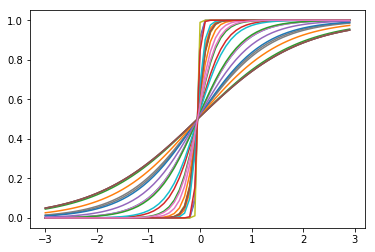

In [8]:
xs = np.arange(-3, 3, .1)
for k in all_k.values:
    plt.plot(xs, logistic(1, 0.5, 1/k, xs))
    
# Hard to qualify verbally, but this is a visualization of the smoothnesses

###### Assess quality of fit

In [16]:
# Get model predictions
df_ppc = df.copy()
df_ppc['model_1_prediction'] = np.nan
df_ppc['model_2_prediction'] = np.nan
df_ppc['model_3_prediction'] = np.nan
df_ppc['model_4_prediction'] = np.nan
df_ppc['winning_model_prediction'] = np.nan
df_ppc['winning_model_no4_prediction'] = np.nan

# data frame with only winning models
to_include = res_df.loc[res_df.distribution=='nbinom']
to_include['bic_minus_minbic'] = to_include.groupby(['subject_id', 'stain'])['bic'].apply(lambda x: x-x.min())
winners = to_include.loc[to_include.bic_minus_minbic == 0]

for subject_id in df_ppc['subject_id'].unique():
    for stain in df_ppc['stain'].unique():
        idx_data = (df_ppc['subject_id'] == subject_id) & (df_ppc['stain'] == stain)
        
        for model in [1,2,3,4]:
            idx_res = (res_df['subject_id'] == subject_id) & (res_df['stain'] == stain) & (res_df['model'] == model) & (res_df['distribution'] == 'nbinom')
            pars = res_df.loc[idx_res, 'res'].apply(lambda x: get_if_exists(x, 'x')).iloc[0]
            df_ppc.loc[idx_data, 'model_'+str(model)+'_prediction'] = get_ev(pars, model, 
                                                                             df_ppc.loc[idx_data, 'pc1_mm_norm'],
                                                                             df_ppc.loc[idx_data, 'pc2_mm_norm'],
                                                                             df_ppc.loc[idx_data, 'slice_mm_norm'],
                                                                             return_projection_axis=False)
            if model > 1:
                df_ppc.loc[idx_data, 'model_'+str(model)+'_pa'] = get_ev(pars, model, 
                                                                             df_ppc.loc[idx_data, 'pc1_mm_norm'],
                                                                             df_ppc.loc[idx_data, 'pc2_mm_norm'],
                                                                             df_ppc.loc[idx_data, 'slice_mm_norm'],
                                                                             return_projection_axis=True)
        
        # get winning model
        winning_model = winners.loc[(winners['bic_minus_minbic']==0) & (winners['subject_id']==subject_id) & (winners['stain']==stain), 'model_dist'].iloc[0]
        idx_res = (res_df['subject_id'] == subject_id) & (res_df['stain'] == stain) & (res_df['model_dist'] == winning_model)
        winning_pars = res_df.loc[idx_res, 'res'].apply(lambda x: get_if_exists(x, 'x')).iloc[0]
        df_ppc.loc[idx_data, 'winning_model_prediction'] = get_ev(winning_pars, float(winning_model[0]), 
                                                                  df_ppc.loc[idx_data, 'pc1_mm_norm'],
                                                                  df_ppc.loc[idx_data, 'pc2_mm_norm'],
                                                                  df_ppc.loc[idx_data, 'slice_mm_norm'],
                                                                  return_projection_axis=False)

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [ ]:
# ### Plot fit per subject/stain in separate files
# from matplotlib.backends.backend_pdf import PdfPages
# if not os.path.exists('./fits'):
#     os.makedirs('fits')

# for subject_id in subjects:
#     for stain in stains:
#         fn = 'fits/sub-{}_stain-{}_fits.pdf'.format(subject_id, stain)
#         pdf = PdfPages(fn)
        
#         for distribution in distributions:
#             for model_n in [1,2,3,4]:
#                 idx = (res_df.subject_id == subject_id) & (res_df.model == model_n) & (res_df.stain == stain) & (res_df.distribution == distribution)
#                 data_idx = (df.subject_id == subject_id) & (df.stain == stain)
#                 fit_result = res_df.loc[idx, 'res'].iloc[0]
                
#                 data_ppc = df.loc[data_idx].copy()
#                 data_ppc['y_predicted'] = get_ev(fit_result['x'], model_n, data_ppc['pc1_mm_norm'].values, data_ppc['pc2_mm_norm'].values, data_ppc['slice_mm_norm'].values)

#                 if model_n > 1:
#                     data_ppc['projection_axis'] = get_ev(fit_result['x'], model_n, data_ppc['pc1_mm_norm'].values, data_ppc['pc2_mm_norm'].values, data_ppc['slice_mm_norm'].values, return_projection_axis=True)

#                 data_ppc['residuals'] = data_ppc['y_predicted']-data_ppc['rate']
#                 wBIC = np.round(res_df.loc[idx, 'wbic'].iloc[0],3)
                
#                 f = plot_single_pc(data_ppc, type='_sector_number')
#                 f.tight_layout()
#                 f.subplots_adjust(top=.90)
#                 f.suptitle('{}/{}/{}/{}\nwBIC: {}'.format(subject_id, stain, model_n, distribution, wBIC))
                
#                 f.set_size_inches(10, 8)
#                 pdf.savefig(f)
#         pdf.close()

/home/stevenm/git_projects/histochemical_mri_stn/notebooks/plotting_functions.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['pc1_sector_name'] = 'vmd_' + df['pc1_sector_number'].astype(int).astype(str)
/home/stevenm/git_projects/histochemical_mri_stn/notebooks/plotting_functions.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['pc2_sector_name'] = 'mml_' + df['pc2_sector_number'].astype(int).astype(str)


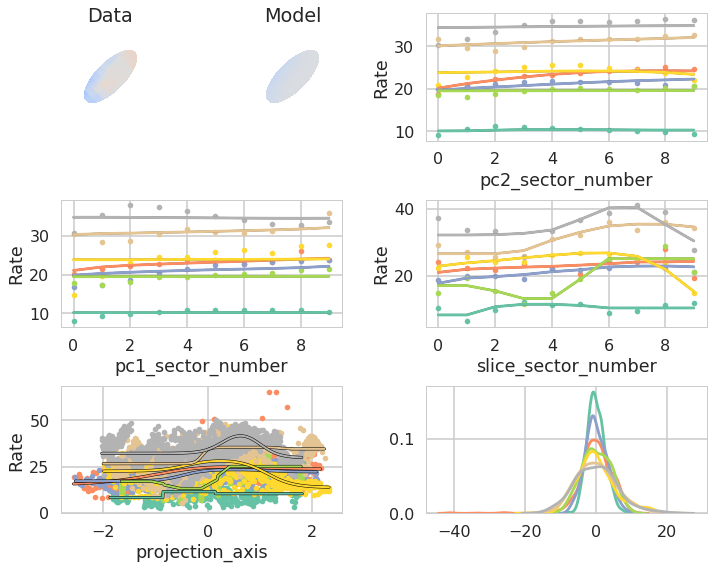

In [18]:
# Generate plots illustrating quality of fit across specimen
def plot_single_pc_ms(df, type='_mm_norm', pred_column=['y_predicted'], projection_axis_name=None):
    """
    Plots the STN, collapsing over a dimension
    """
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import matplotlib.patheffects as pe
    gs = gridspec.GridSpec(3, 4)
    ax_stn_data = plt.subplot(gs[0,0])
    ax_stn_model = plt.subplot(gs[0,1])
    
    ax_graph1 = plt.subplot(gs[1,0:2])
    ax_graph2 = plt.subplot(gs[0,2:4])
    ax_graph3 = plt.subplot(gs[1,2:4])
    
    proj_axis = plt.subplot(gs[2,0:2])
    residuals_ax = plt.subplot(gs[2,2:4])
    
    vmin, vmax = np.nanpercentile(df['rate'], [5, 95])

    visualize_stn_model(df, dependent_var='rate', ax=ax_stn_data, vmin=vmin, vmax=vmax)
    visualize_stn_model(df, dependent_var=pred_column, ax=ax_stn_model, vmin=vmin, vmax=vmax)
    
    subs = df.subject_id.unique()
    cmap = plt.get_cmap('Set2')
    colors = [cmap(i) for i in np.linspace(0, 1, subs.shape[0])]
    
    # data...
    for sub, color in zip(subs, colors):
        df_sub = df.loc[df.subject_id==sub]
        plot_intensity_across_axis(df_sub, dependent_var='rate', ax=ax_graph1, x_axis='pc1'+type, 
                                   label=sub, linestyle="", marker=".", color=color)
        plot_intensity_across_axis(df_sub, dependent_var='rate', ax=ax_graph2, x_axis='pc2'+type, 
                                   label=sub, linestyle="", marker=".", color=color)
        plot_intensity_across_axis(df_sub, dependent_var='rate', ax=ax_graph3, x_axis='slice'+type, 
                                   label=sub, linestyle="", marker=".", color=color)

        if projection_axis_name is not None and projection_axis_name in df_sub.columns:
            df_sub = df_sub.sort_values(projection_axis_name)
            proj_axis.plot(df_sub[projection_axis_name], df_sub["rate"], '.', label='data', color=color)
            proj_axis.set_xlabel('projection_axis')
            proj_axis.set_ylabel('Rate')

    # predictions...
    for sub, color in zip(subs, colors):
        df_sub = df.loc[df.subject_id==sub]
        plot_intensity_across_axis(df_sub, dependent_var=pred_column, ax=ax_graph1, x_axis='pc1'+type, label=None, 
                                   color=color, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
        plot_intensity_across_axis(df_sub, dependent_var=pred_column, ax=ax_graph2, x_axis='pc2'+type, label=None, 
                                   color=color, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
        plot_intensity_across_axis(df_sub, dependent_var=pred_column, ax=ax_graph3, x_axis='slice'+type, label=None,
                                   color=color, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

        if projection_axis_name is not None and projection_axis_name in df_sub.columns:
            df_sub = df_sub.sort_values(projection_axis_name)
            proj_axis.plot(df_sub[projection_axis_name], df_sub[pred_column], linewidth=2, label='model', 
                           color=color, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
            proj_axis.set_xlabel('projection_axis')
            proj_axis.set_ylabel('Rate')

        sns.kdeplot(df_sub[pred_column] - df_sub['rate'], ax=residuals_ax, color=color)

    ax_stn_data.set_title('Data')
    ax_stn_model.set_title('Model')
#     ax_graph1.legend()
#     ax_graph2.legend()
#     ax_graph3.legend()
    
    return plt.gcf()

for stain in stains:
    fn = 'fits/stain-{}_fits.pdf'.format(stain)
    pdf = PdfPages(fn)

    for model in [1,2,3,4]:
        f = plot_single_pc_ms(df_ppc.loc[df_ppc.stain==stain], 
                              type='_sector_number', 
                              pred_column='model_' + str(model) + '_prediction',
                              projection_axis_name='model_' + str(model) + '_pa')
        f.tight_layout()
        f.set_size_inches(10, 8)
        pdf.savefig(f)
    pdf.close()

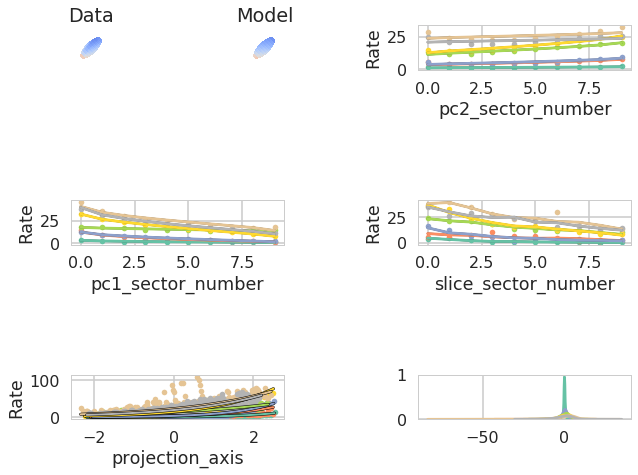

In [36]:
# Example plot here
model = 2
f = plot_single_pc_ms(df_ppc.loc[df_ppc.stain=='CALR'], 
                      type='_sector_number', 
                      pred_column='model_' + str(model) + '_prediction',
                      projection_axis_name='model_' + str(model) + '_pa')
f.tight_layout()
f.set_size_inches(10, 8)

##### In general, the models seem to fit the general patterns in the data well

## 4c) Model comparison
1. Lowest sum BIC per model
2. Highest mean wBIC per model

2 is more robust to "outliers" in the fit quality

In [1]:
# # lowest sum BIC per model
# to_include = res_df.loc[res_df.distribution=='nbinom']
# to_include['bic_minus_minbic'] = to_include.groupby(['subject_id', 'stain'])['bic'].apply(lambda x: x-x.min())
# to_include['wbic'] = to_include.groupby(['subject_id', 'stain'])['bic_minus_minbic'].apply(lambda x: np.exp(-.5*x) / np.sum(np.exp(-.5*x)))

# winners = to_include.loc[to_include.bic_minus_minbic == 0]
# winners_table = winners.pivot_table(index=['subject_id'], columns='stain', values='model', aggfunc=lambda x: x)
# winners_table[finished>0] = np.nan

# # overall winner across specimen
# winners_across_specimen = to_include.copy().groupby(['stain', 'model'])['bic'].apply(lambda x: x.sum())
# winners_across_specimen = winners_across_specimen.reset_index().groupby('stain').apply(lambda x: x['model'][np.argmin(x['bic'])])
# winners_across_specimen = pd.DataFrame(winners_across_specimen).T
# winners_across_specimen.index = ['Across specimen']
# winners_across_specimen.index.name = 'subject_id'
# winners_table = winners_table.append(winners_across_specimen)

# # Overall winners across stains
# winners_across_stains = to_include.copy().groupby(['subject_id', 'model'])['bic'].apply(lambda x: x.sum())
# winners_across_stains = winners_across_stains.reset_index().groupby('subject_id').apply(lambda x: x['model'][np.argmin(x['bic'])])
# winners_across_stains = pd.DataFrame(winners_across_stains)
# winners_across_stains.columns = ['overall']
# winners_table['Across stains'] = winners_across_stains['overall']

# # Overall winner across everything
# winner_overall = to_include.copy().groupby('model')['bic'].apply(lambda x: x.sum())
# winner_overall = winner_overall.index[np.argmin(winner_overall.values)]
# winners_table.loc['Across specimen', 'Across stains'] = winner_overall

# winners_table

In [10]:
# Highest mean weighted BIC
to_include = res_df.loc[res_df.distribution=='nbinom']
to_include['bic_minus_minbic'] = to_include.groupby(['subject_id', 'stain'])['bic'].apply(lambda x: x-x.min())
to_include['wbic'] = to_include.groupby(['subject_id', 'stain'])['bic_minus_minbic'].apply(lambda x: np.exp(-.5*x) / np.sum(np.exp(-.5*x)))

winners = to_include.loc[to_include.bic_minus_minbic == 0]
winners_table = winners.pivot_table(index=['subject_id'], columns='stain', values='model', aggfunc=lambda x: x)
winners_table[finished>0] = np.nan

# overall winner across specimen
winners_across_specimen = to_include.copy().groupby(['stain', 'model'])['wbic'].mean()
winners_across_specimen = winners_across_specimen.reset_index().groupby('stain').apply(lambda x: x['model'][np.argmax(x['wbic'])])
winners_across_specimen = pd.DataFrame(winners_across_specimen).T
winners_across_specimen.index = ['Across specimen']
winners_across_specimen.index.name = 'subject_id'
winners_table = winners_table.append(winners_across_specimen)

# Overall winners across stains
winners_across_stains = to_include.copy().groupby(['subject_id', 'model'])['wbic'].mean()
winners_across_stains = winners_across_stains.reset_index().groupby('subject_id').apply(lambda x: x['model'][np.argmax(x['wbic'])])
winners_across_stains = pd.DataFrame(winners_across_stains)
winners_across_stains.columns = ['overall']
winners_table['Across stains'] = winners_across_stains['overall']

# Overall winner across everything
winner_overall = to_include.copy().groupby('model')['wbic'].mean()
winner_overall = winner_overall.index[np.argmax(winner_overall.values)]
winners_table.loc['Across specimen', 'Across stains'] = winner_overall

winners_table

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. 

stain,CALR,FER,GABRA3,GAD6567,MBP,PARV,SERT,SMI32,SYN,TH,TRANSF,VGLUT1,Across stains
subject_id,,,,,,,,,,,,,
13095,2,2,4,2,4,4,3,2,4,2,4,2,2.0
14037,2,2,2,2,2,2,2,2,4,4,2,4,2.0
14051,2,4,2,2,4,4,2,2,4,2,4,2,2.0
14069,2,2,2,2,4,2,2,3,3,3,3,4,2.0
15033,2,2,2,2,2,2,2,2,2,2,2,2,2.0
15035,2,3,4,2,2,4,2,4,2,2,2,3,2.0
15055,2,2,4,2,4,4,2,4,4,4,2,4,4.0
Across specimen,2,2,2,2,4,4,2,2,4,2,2,2,2.0


In [11]:
7/84

0.08333333333333333

In [15]:
np.sum(winners_table.iloc[:-1, :-1] == 4).sum() / 84

0.2976190476190476

## 4d) Plot model STN versus data

Since model 2 is the overall winning model, we plot this model's predictions.

For visualization purposes, we collapse every two slices; such that only 5 slices are plotted

In [17]:
# Generate string sector labels for plotting
df_ppc['slice_5'] = np.floor(df['slice_sector_number']/2)
df_ppc['pc1_sector_labels'] = 'vmd_' + df_ppc['pc1_sector_number'].astype(int).astype(str)
df_ppc['pc2_sector_labels'] = 'mml_' + df_ppc['pc2_sector_number'].astype(int).astype(str)
df_ppc['slice_sector_labels'] = 'pma_' + df_ppc['slice_5'].astype(int).astype(str)

# Set all intensity expressions on a common scale for plotting
for col in ['model_1_prediction', 'model_2_prediction', 'model_3_prediction', 
            'model_4_prediction', 'winning_model_prediction', 'winning_model_no4_prediction']:
    df_ppc[col + '_norm'] = df_ppc[col] - df_ppc.groupby(['subject_id', 'stain'])['rate'].transform(np.mean)
    df_ppc[col + '_norm'] = df_ppc[col + '_norm'] / df_ppc.groupby(['subject_id', 'stain'])['rate'].transform(np.std)
    
df_ppc['rate_norm'] = df_ppc.groupby(['subject_id', 'stain'])['rate'].apply(lambda x: (x-x.mean())/x.std())

# Additional settings for plotting
n_sectors_per_axis = 10
n_slices = 5

0 4 0 3 0 2 0 1 0 0 1 4 1 3 1 2 1 1 1 0 2 4 2 3 2 2 2 1 2 0 3 4 3 3 3 2 3 1 3 0 0 9 0 8 0 7 0 6 0 5 1 9 1 8 1 7 1 6 1 5 2 9 2 8 2 7 2 6 2 5 3 9 3 8 3 7 3 6 3 5 0 14 0 13 0 12 0 11 0 10 1 14 1 13 1 12 1 11 1 10 2 14 2 13 2 12 2 11 2 10 3 14 3 13 3 12 3 11 3 10 0 4 0 3 0 2 0 1 0 0 1 4 1 3 1 2 1 1 1 0 2 4 2 3 2 2 2 1 2 0 3 4 3 3 3 2 3 1 3 0 0 9 0 8 0 7 0 6 0 5 1 9 1 8 1 7 1 6 1 5 2 9 2 8 2 7 2 6 2 5 3 9 3 8 3 7 3 6 3 5 0 14 0 13 0 12 0 11 0 10 1 14 1 13 1 12 1 11 1 10 2 14 2 13 2 12 2 11 2 10 3 14 3 13 3 12 3 11 3 10 

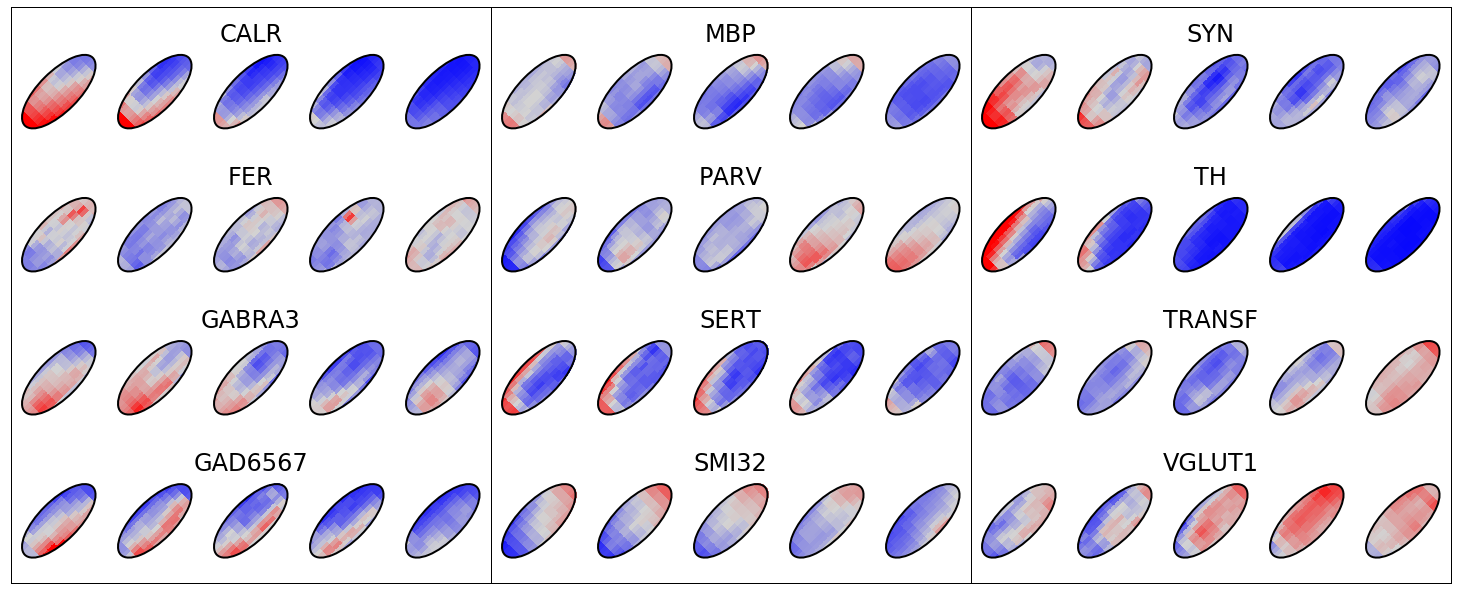

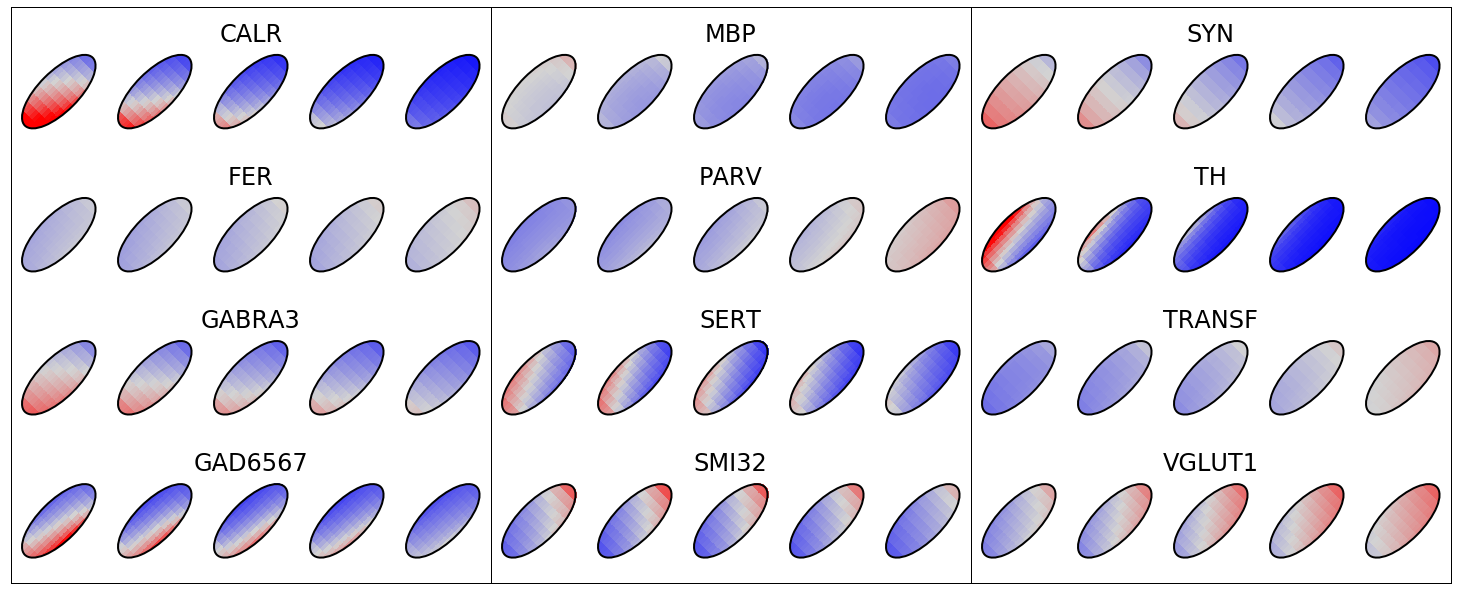

In [19]:
vminmax = df_ppc.groupby('stain').rate_norm.apply(lambda x: np.percentile(x, [5, 95])).to_dict()
from matplotlib.backends.backend_pdf import PdfPages

plot_stns(df_ppc, y_type='rate_norm', vminmax = vminmax)
fn = '/home/stevenm/data/post_mortem/visualize_stains_v2/glms/data.pdf'
pdf = PdfPages(fn)
plt.gcf().savefig(pdf,  format='pdf')
pdf.close()

plot_stns(df_ppc, y_type='model_2_prediction_norm', vminmax = vminmax)
fn = '/home/stevenm/data/post_mortem/visualize_stains_v2/glms/model.pdf'
pdf = PdfPages(fn)
plt.gcf().savefig(pdf,  format='pdf')
pdf.close()
